In [2]:
from tensorflow.keras.applications import xception
from tensorflow.keras.applications import resnet50,ResNet50
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

1/1 [==============================] - 1s 808ms/step
예측 : [('n02013706', 'limpkin', 0.15470083), ('n02442845', 'mink', 0.040437855), ('n01518878', 'ostrich', 0.03998313), ('n02009229', 'little_blue_heron', 0.019928578), ('n02326432', 'hare', 0.01668087)]


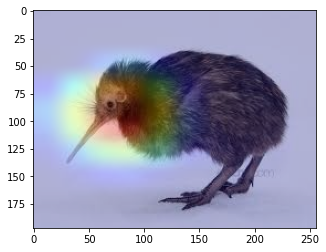

In [4]:

model = xception.Xception(weights='imagenet')
image_path = './newBird.jpg'
img = image.load_img(image_path,target_size=(299,299))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
x = xception.preprocess_input(x)
preds = model.predict(x)
print(f"예측 : {xception.decode_predictions(preds,top=5)[0]}")
# xception.decode_predictions(preds,top=5)[0]
last_conv_layer = model.get_layer("block14_sepconv2_act")
model_1 = keras.Model(model.inputs,last_conv_layer.output)
input_2 = keras.Input(shape=last_conv_layer.output.shape[1:])
x_2 = model.get_layer('avg_pool')(input_2)
x_2=model.get_layer('predictions')(x_2)
model_2 = keras.Model(input_2,x_2)
with tf.GradientTape() as tape:
    output_1 = model_1(x)
    tape.watch(output_1)
    preds = model_2(output_1)
    class_id = tf.argmax(preds[0])
    output_2 = preds[:,class_id]
grads = tape.gradient(output_2,output_1)
pooled_grads = tf.reduce_mean(grads,axis=(0,1,2))
output_1 = output_1.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    output_1[:,:,i]*= pooled_grads[i]
heatmap = np.mean(output_1,axis=-1)    
heatmap = np.maximum(heatmap,0) / np.max(heatmap)
plt.imshow(heatmap)
img = image.load_img(image_path)
img=image.img_to_array(img)
heatmap = np.uint8(255*heatmap)  # [0,255]로 변환
jet = cm.get_cmap('jet')
color = jet(np.arange(256))[:,:3]
color_heatmap = color[heatmap]
color_heatmap = keras.preprocessing.image.array_to_img(color_heatmap)
color_heatmap = color_heatmap.resize( (img.shape[1], img.shape[0]) )
color_heatmap = keras.preprocessing.image.img_to_array(color_heatmap)
overlay_img=color_heatmap*0.4+img
overlay_img=keras.preprocessing.image.array_to_img(overlay_img)
plt.imshow(overlay_img)